In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from affinewarp import PiecewiseWarping

Populating the interactive namespace from numpy and matplotlib


In [2]:
n_knots = 1
model = PiecewiseWarping(n_knots=n_knots)

In [3]:
n_trials = 1000
n_time = 100
n_neuron = 10
model.initialize_warps(n_trials)
model.x_knots, model.y_knots = model._mutate_knots(0.1);
model.y_knots[:, 0] = 0.
model.y_knots[:, -1] = 1.

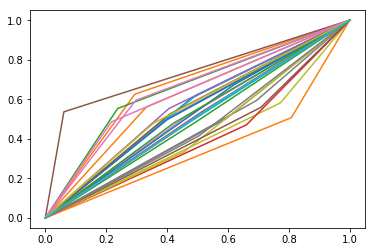

In [4]:
plot(model.x_knots[:30].T, model.y_knots[:30].T);

In [5]:
template = np.random.rand(n_time, n_neuron)
from scipy.ndimage import gaussian_filter1d
template_sigma = n_time / 50.
template = gaussian_filter1d(template, template_sigma, axis=0)
aligned_data = np.tile(template[None, ...], (n_trials, 1, 1))
data = model.transform(aligned_data)

In [6]:
model.template = template
data = model.predict()
data += .1 * np.random.randn(*data.shape)

In [7]:
from affinewarp.visualization import binned_heatmap

In [17]:
model_fit = PiecewiseWarping(n_knots=n_knots, l2_reg_scale=0.0,
                             smoothness_reg_scale=0.0, warp_reg_scale=0.0, n_restarts=1)
model_fit.fit(data, iterations=10, warp_iterations=200)

100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


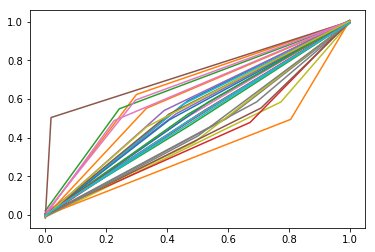

In [18]:
plt.plot(model_fit.x_knots[:30].T, model_fit.y_knots[:30].T);

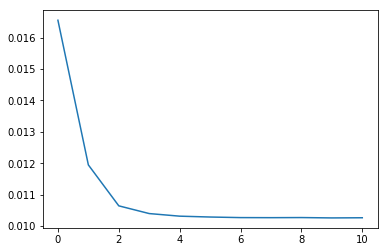

In [19]:
plot(model_fit.loss_hist)

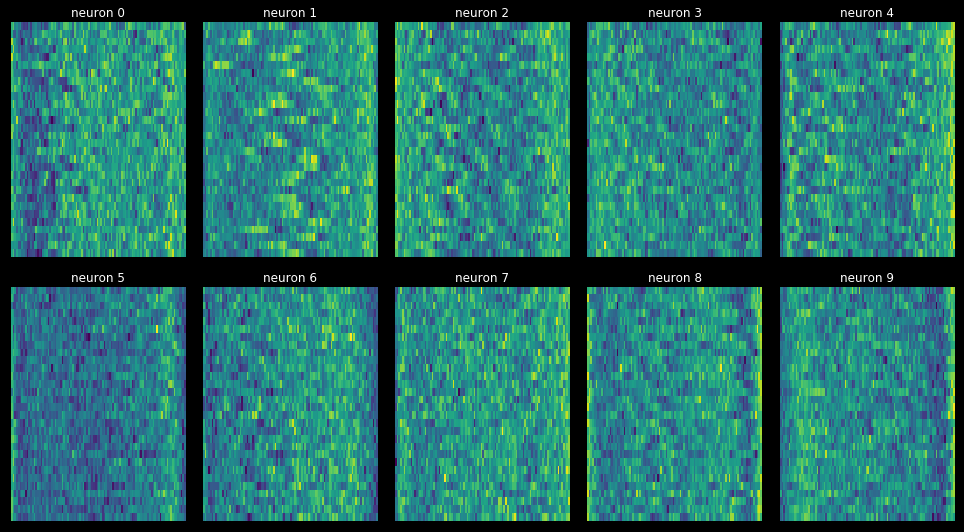

In [20]:
binned_heatmap(data[:30], subplots=(2,5));

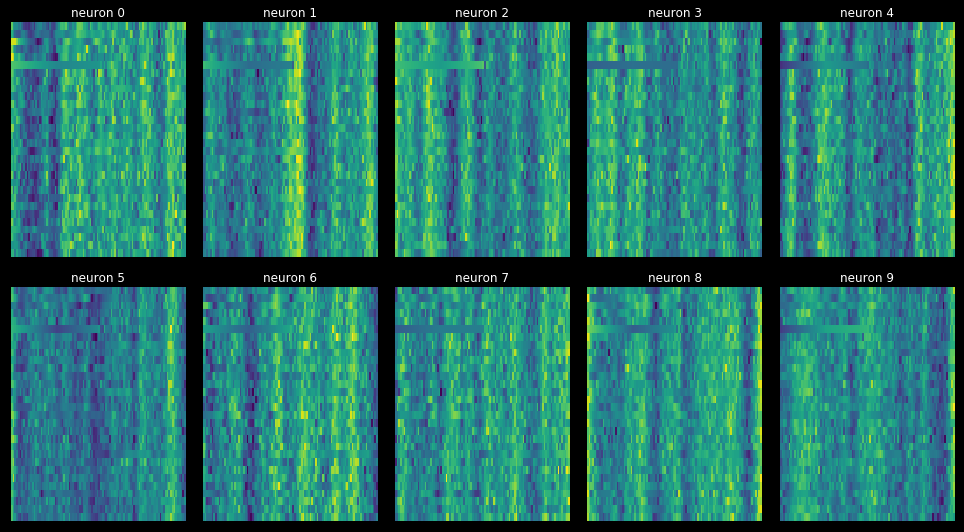

In [21]:
binned_heatmap(model_fit.transform(data)[:30], subplots=(2,5));

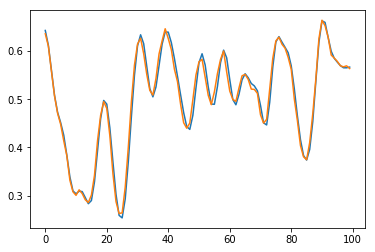

In [22]:
plt.plot(model.template[:,0])
plt.plot(model_fit.template[:,0])